# Road Sign Detection using MobileNetV1

- Author: **Kaushal Bhavsar**
- LinkedIn : https://www.linkedin.com/in/kb07/
- Github: Mister-kaushalam
- Email - Kaushalbhavsar0007@gmail.com

**Original Souces**:
<br><br>
DataSet - https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/data

Data loading and some visuailization started code taken from : https://www.kaggle.com/code/divakaivan12/traffic-sign-classification-and-bbox-model-pytorch

MobileNet Model Implementation code: https://www.kaggle.com/code/sonukiller99/mobilenet-from-scratch

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

import random

import os
import cv2
from PIL import Image

from tqdm import tqdm
import albumentations as A
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score



import time
import torch
import torch.nn as nn
import torch.optim as optim

if torch.cuda.is_available():
    print("GPU is available.")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU instead.")
    device = torch.device("cpu")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from bayes_opt import BayesianOptimization


GPU is available.


#  The Data Set

## Reading and loading the dataset

In [2]:
base_dir = r"C:\Users\kaush\OneDrive\Documents\UL Code\CNN project\\"

In [3]:
df = pd.read_csv(str(base_dir) + "\\" + 'Train.csv')

df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
test_df = pd.read_csv(str(base_dir) + "\\" + 'Test.csv')

test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


## Data preprocessing

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, base_dir = ""):
        """
            Constructor for the CustomDataset class.

            Parameters:
            - dataframe: Pandas DataFrame containing image paths, bounding box coordinates, and class labels.
            - transform: Optional, a transformation to be applied to the images and bounding boxes.
            - base_dir: Optional, base directory for the image paths.
        """
        self.dataframe = dataframe
        self.transform = transform
        self.base_dir = base_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
            Retrieves an item from the dataset.

            Parameters:
            - idx: Index of the item to retrieve.

            Returns:
            - img: Transformed image.
            - class_id: Class ID of the object in the image.
            - bbox: Bounding box coordinates of the object in the image.
        """
        # get img
        img_path = str(self.base_dir) + self.dataframe.iloc[idx]['Path']
        img = Image.open(img_path).convert('RGB')

        # get bbox
        row = self.dataframe.iloc[idx]
        xmin = row['Roi.X1']
        ymin = row['Roi.Y1']
        xmax = row['Roi.X2']
        ymax = row['Roi.Y2']
        bbox = [[xmin, ymin, xmax,ymax]]

        # get class
        class_id = self.dataframe.iloc[idx]['ClassId']

        # Apply transformation if specified
        if self.transform:
            augmented = self.transform(image=np.array(img), bboxes=bbox, ClassId=[class_id])
            img = augmented['image']
            bbox = augmented['bboxes'][0]
            class_id = augmented['ClassId'][0]

        # Convert image and bounding box to torch tensors
        # Normalize image and change dimension order
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0 # (h, w, c) -> (c, h, w)
        bbox = torch.Tensor(bbox)

        return img, class_id, bbox

Augmentation pipelines for training, validation, and testing sets

In [6]:
train_augs = A.Compose([
    A.Resize(224, 224), # Resize images to 224x224
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['ClassId']))

val_augs = A.Compose([
    A.Resize(224, 224),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['ClassId']))

test_augs = A.Compose([
    A.Resize(224, 224),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['ClassId']))

Creating the validation data from the training data

In [7]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
train = CustomDataset(train_df, train_augs, base_dir)
val = CustomDataset(val_df, val_augs, base_dir)

len(train), len(val)

(31367, 7842)

In [9]:
test = CustomDataset(test_df, test_augs, base_dir)

len(test)

12630

In [10]:
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=32)
test_loader = torch.utils.data.DataLoader(test, batch_size=32)

## Data Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


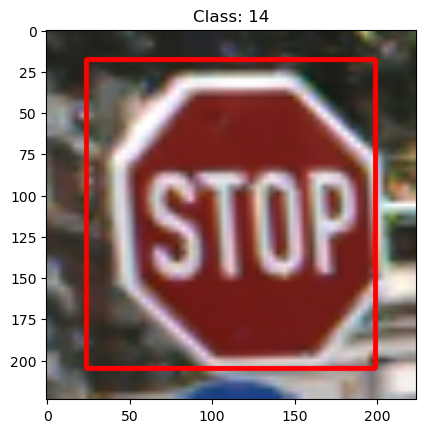

In [11]:
# Retrieve image, class ID, and bounding box from validation dataset
img, class_id, bbox = val[1]

# Extract bounding box coordinates
xmin, ymin, xmax, ymax = bbox
pt1 = (int(xmin), int(ymin)) # Top-left corner
pt2 = (int(xmax), int(ymax))  # Bottom-right corner

# Check if the image is a torch Tensor and convert it to a numpy array if necessary
if isinstance(img, torch.Tensor):
    img = img.permute(1, 2, 0).numpy() # Convert tensor to numpy array and rearrange dimensions
else:
    img = img

print(img.shape)

# Draw bounding box on the image
bnd_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)

# Display the image with bounding box
plt.imshow(bnd_img)
plt.title('Class: '+ str(class_id));

### Visualisation of some of the key attributes

<Axes: title={'center': 'Test Set - Traffic Sign Class Distribution'}, xlabel='ClassId', ylabel='count'>

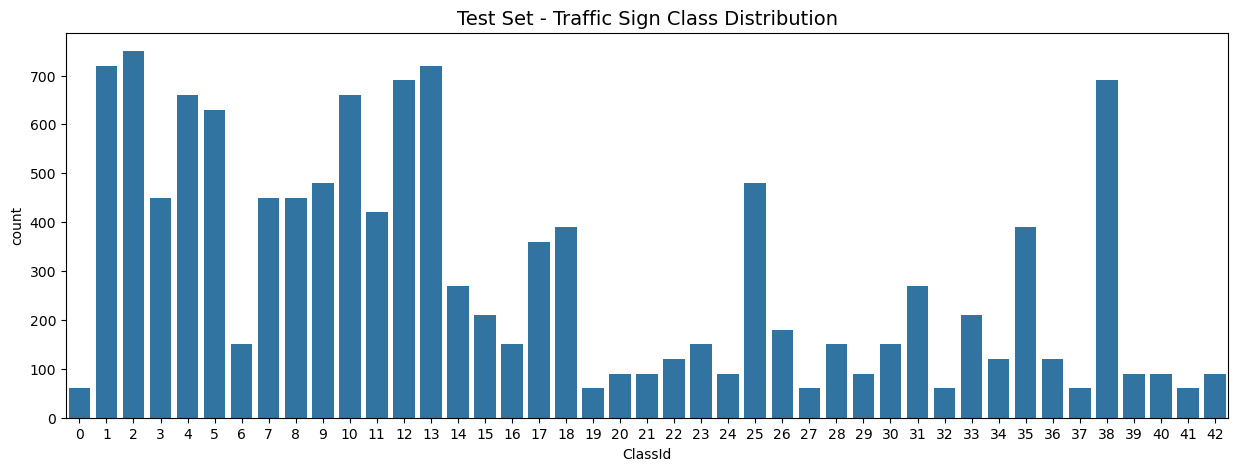

In [12]:
# Visualization of Test Set
plt.figure(figsize=(15, 5))
plt.title('Test Set - Traffic Sign Class Distribution', fontsize= 14)
seaborn.countplot(x = "ClassId", data = test_df)

<Axes: title={'center': 'Train Set - Traffic Sign Class Distribution'}, xlabel='ClassId', ylabel='count'>

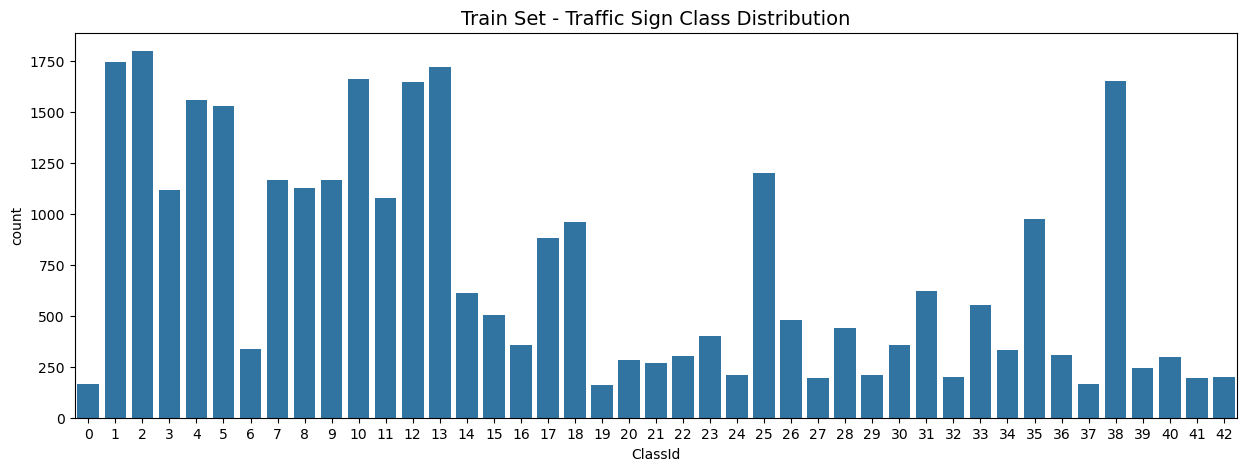

In [13]:
# Visualization of Train Set
plt.figure(figsize=(15, 5))
plt.title('Train Set - Traffic Sign Class Distribution', fontsize= 14)
seaborn.countplot(x = "ClassId", data = train_df)

<Axes: title={'center': 'Validation Set - Traffic Sign Class Distribution'}, xlabel='ClassId', ylabel='count'>

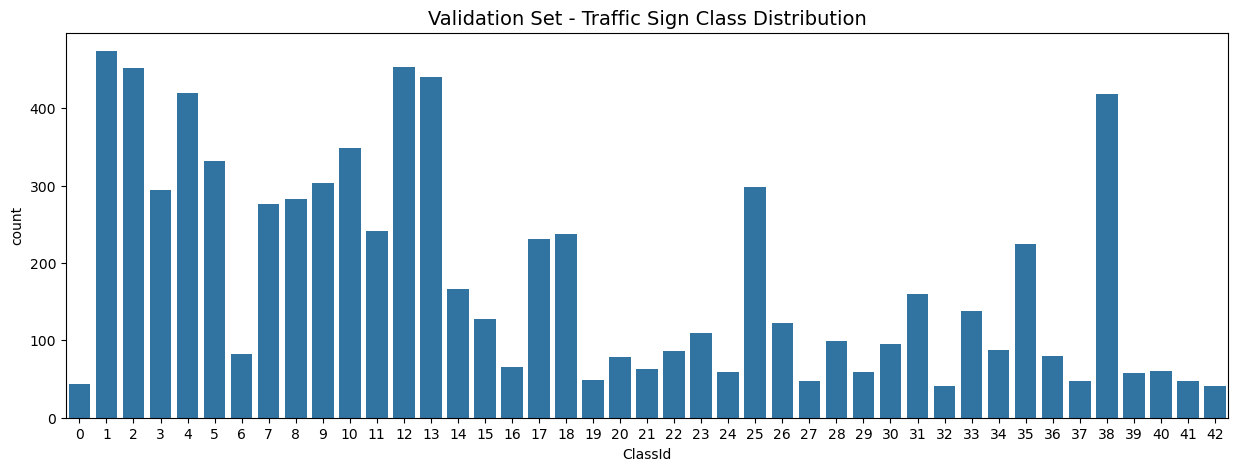

In [14]:
# Visualization of Validation Set
plt.figure(figsize=(15, 5))
plt.title('Validation Set - Traffic Sign Class Distribution', fontsize= 14)
seaborn.countplot(x = "ClassId", data = val_df)

# The network structure and other hyperparameters

## Create the MobileNet Model Class

In [11]:
# Define a convolutional block with regular convolution
class Convolution_Block(nn.Module):
    def __init__(self, in_channels, stride=1):
        super().__init__()
        padding_ = 'same' if stride==1 else 'valid' # Determine padding based on the stride value
        self.conv = nn.Conv2d(in_channels, 2*in_channels, 3, padding=padding_, stride=stride)
        self.batch_norm = nn.BatchNorm2d(2*in_channels)

    # Forward pass through convolutional layer
    def forward(self, x):
        x = self.conv(x) #convolution
        x = self.batch_norm(x) #batch normalization
        x = F.relu(x) #activation function

        return x

# Define a convolutional block with depthwise separable convolution
class Depth_Convolution_Block(nn.Module):
    def __init__(self, in_channels, stride=2):
        super().__init__()
        padding_ = 'same' if stride==1 else 'valid'
        self.depth_conv = nn.Conv2d(in_channels, in_channels, 3, groups=in_channels,
                                    stride=stride, padding=padding_)
        self.batch_norm = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        x = self.depth_conv(x) #depthwise convolution
        x = self.batch_norm(x) #batch normalization
        x = F.relu(x) #activation function

        return x

# Define a convolutional block with regular convolution and 'same' padding
class Convolution_Block_Same(nn.Module):
    def __init__(self, in_channels, stride=1):
        super().__init__()
        padding_ = 'same' if stride==1 else 'valid'
        self.conv = nn.Conv2d(in_channels, in_channels, 3, padding=padding_, stride=stride)
        self.batch_norm = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        x = self.conv(x) #convolution
        x = self.batch_norm(x) #batch normalization
        x = F.relu(x) #activation function

        return x

In [12]:
# Creating the MobileNet model
class MyMobileNet(nn.Module):
    def __init__(self, in_channels, classes=2):
        super().__init__()

        # First set of convolutional layers
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, stride=2), # Convolutional layer with stride 2
            nn.BatchNorm2d(32), # Batch normalization
            nn.ReLU(), #activation function
            Depth_Convolution_Block(32, stride=1), # Depthwise separable convolutional block
            Convolution_Block(32),
            Depth_Convolution_Block(64),
            Convolution_Block(64),
            Depth_Convolution_Block(128, stride=1),
            Convolution_Block_Same(128),  # Convolutional block with 'same' padding
            Depth_Convolution_Block(128),
            Convolution_Block(128), 
            Depth_Convolution_Block(256, stride=1),
            Convolution_Block_Same(256),
            Depth_Convolution_Block(256, stride=2),
            Convolution_Block(256),)
        
        # Define lists to create same repeating layers in order to avoid explicit coding
        # This also help later in the code to reduce and increase number of layers for engineering overfitting and underfitting
        self.list = []
        self.module_list_depth = nn.ModuleList([Depth_Convolution_Block(512, stride=1) for i in range(5)])
        self.module_list_conv = nn.ModuleList([Convolution_Block_Same(512) for i in range(5)])

        # Second set of convolutional layers
        self.layers2 = nn.Sequential(
            Depth_Convolution_Block(512, stride=2), # Depthwise separable convolutional block with stride 2
            Convolution_Block(512),
            Depth_Convolution_Block(1024, stride=2),
            Convolution_Block_Same(1024),
            nn.AdaptiveAvgPool2d(7), # Adaptive average pooling layer
            nn.Flatten(), # Flatten the output
            nn.Linear(7*7*1024, classes), # Fully connected layer
            )

    def forward(self, x):
        # Forward pass through the first set of layers
        x = self.layers1(x)

        # Forward pass through the depthwise and convolutional blocks in the lists
        for layer1, layer2 in zip(self.module_list_depth, self.module_list_conv):
            x = layer1(x)
            x = layer2(x)

        # Forward pass through the second set of layers
        x = self.layers2(x)

        #softmax function is not used because nn.crossentropyloss function incorporates the softmax operation internally
        return x

Create an instance of the MyMobileNet model and load it to the GPU (or cpu)

In [13]:
model = MyMobileNet(3, classes = 43)
model.to(device)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             896
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
            Conv2d-4         [-1, 32, 111, 111]             320
       BatchNorm2d-5         [-1, 32, 111, 111]              64
Depth_Convolution_Block-6         [-1, 32, 111, 111]               0
            Conv2d-7         [-1, 64, 111, 111]          18,496
       BatchNorm2d-8         [-1, 64, 111, 111]             128
 Convolution_Block-9         [-1, 64, 111, 111]               0
           Conv2d-10           [-1, 64, 55, 55]             640
      BatchNorm2d-11           [-1, 64, 55, 55]             128
Depth_Convolution_Block-12           [-1, 64, 55, 55]               0
           Conv2d-13          [-1, 128, 55, 55]          73,856
      BatchNorm2d-14        

## Training

This code snippet sets up the loss function as the Cross Entropy Loss (nn.CrossEntropyLoss()) which is commonly used for classification tasks where the model output is a class probability distribution.

Then, it defines the optimizer as the Adam optimizer (optim.Adam) which is a popular choice for training neural networks. It optimizes the parameters of the model with a learning rate of 0.001.

In [18]:
# Define the loss function (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer) for model parameters with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# Initialize lists to store training and validation metrics
train_losses = []  # Training losses
train_accuracies = []  # Training accuracies
val_losses = []  # Validation losses
val_accuracies = []  # Validation accuracies

# Initialize variables to compare and save the best model later
best_val_loss = float('inf') # Set initial best validation loss to infinity
best_model_weights = None # Initialize variable to store the best model weights

epochs = 15
for epoch in range(1, epochs + 1):

    # training
    model.train() # Set the model to train mode
    train_loss = 0.0 # Initialize training loss
    correct_train = 0 # Initialize number of correctly predicted training samples
    total_train = 0 # Initialize total number of training samples

    # Create a progress bar for training data
    train_loader_with_progress = tqdm(train_loader, desc=f'[TRAIN] Epoch {epoch}/{epochs}')

    for images, labels, bboxes in train_loader_with_progress:
        images = images.to(device)
        labels = labels.to(device)
        classification_output = model(images) # Forward pass

        classification_loss_value = criterion(classification_output, labels) #classification loss

        # Backpropagation
        optimizer.zero_grad() # Zero the gradients
        classification_loss_value.backward() # Backpropagate
        optimizer.step() # Update weights

        # Update training metrics
        train_loss += classification_loss_value.item()
        _, predicted = torch.max(classification_output.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        accuracy_train = correct_train / total_train

        # Update progress bar with metrics
        postfix_dict = {'classification loss': classification_loss_value.item(), 'classification acc': accuracy_train }
        train_loader_with_progress.set_postfix(postfix_dict)

    # Compute average training loss and accuracy for the epoch
    train_loss_avg = train_loss / len(train_loader)
    train_acc_avg = correct_train / total_train
    train_losses.append(train_loss_avg)
    train_accuracies.append(train_acc_avg)

    # validation
    model.eval() # Set the model to evaluation mode
    val_loss = 0.0 # Initialize validation loss
    correct_val = 0 # Initialize number of correctly predicted validation samples
    total_val = 0 # Initialize total number of validation samples

    # Create a progress bar for validation data
    val_loader_with_progress = tqdm(val_loader, desc=f'[VALID] Epoch {epoch}/{epochs}')

    with torch.no_grad(): # Disable gradient computation for validation
        for images, labels, bboxes in val_loader_with_progress:
            images = images.to(device)
            labels = labels.to(device)

            classification_output = model(images) # Forward pass

            classification_loss_value = criterion(classification_output, labels) #classification loss

            # Compute validation accuracy
            val_loss += classification_loss_value.item() # Update validation loss
            _, predicted = torch.max(classification_output.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            accuracy_val = correct_val / total_val
            
            # Update progress bar with metrics
            postfix_dict2 = {'classification loss': classification_loss_value.item(), 'classification acc': accuracy_val }
            val_loader_with_progress.set_postfix(postfix_dict2)

    # Compute average validation loss and accuracy for the epoch
    val_loss /= len(val_loader)
    val_loss_avg = val_loss / len(val_loader)
    val_acc_avg = correct_val / total_val
    val_losses.append(val_loss_avg)
    val_accuracies.append(val_acc_avg)

    # # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()

# Save the weights of the best model
torch.save(best_model_weights, str(base_dir) + "/best_model_weights.pt")

[VALID] Epoch 15/15: 100%|██████████| 246/246 [00:20<00:00, 11.95it/s, classification loss=1.67e-6, classification acc=0.989] 


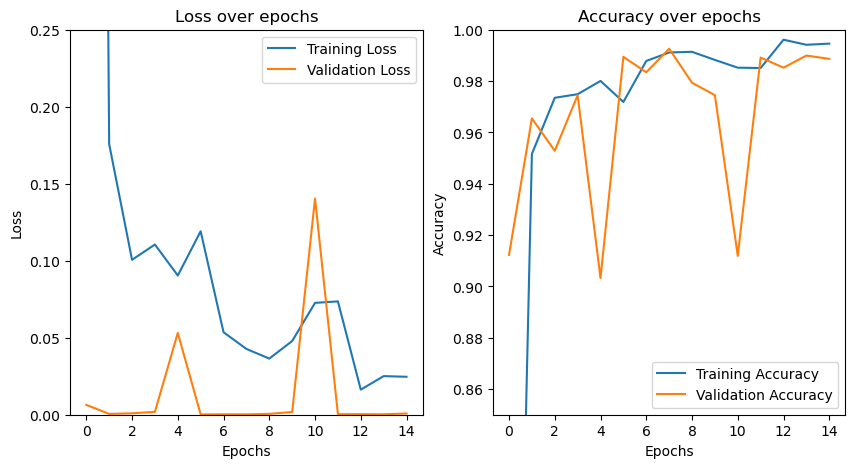

In [20]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # Create subplot 1 in a 1x2 grid
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.ylim(0, 0.25) # Set y-axis limit
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)  # Create subplot 2 in a 1x2 grid
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.ylim(0.85, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

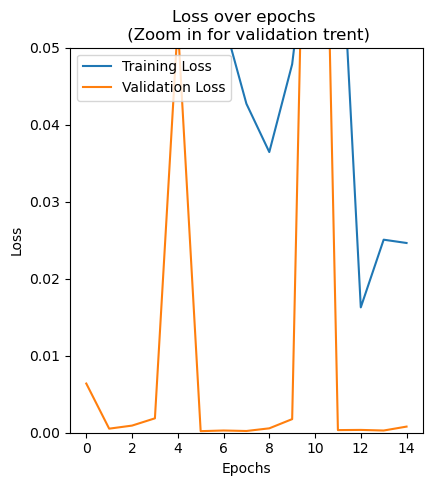

In [21]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.ylim(0, 0.05) # zoom in using y-axis limit
plt.title('Loss over epochs \n (Zoom in for validation trent)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Hyper Parameter tuning - Optimization

In [30]:
# Define a function to optimize
def train_model(lr, weight_decay, optimizer_type="Adam"):
    # Convert optimizer_type and loss_function to their respective objects
    optimizer_cls = optim.Adam if optimizer_type == 'Adam' else optim.SGD
    criterion = nn.CrossEntropyLoss()

    # Instantiate the model
    model = MyMobileNet(3, classes=43).to(device)

    # Instantiate the optimizer with specified parameters
    optimizer = optimizer_cls(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    epochs = 5
    for epoch in range(epochs):
        print(f"[TRAIN] Epoch {epoch+1}")
        model.train() # Set the model to training mode
        for images, labels, _ in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # Zero the parameter gradients
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels) # Calculate the loss
            loss.backward() # Backward pass
            optimizer.step() # Optimize

        print(f"[Valid] Epoch {epoch +1}")
        # Validation loop
        model.eval() # Set the model to evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images) # Forward pass
                _, predicted = torch.max(outputs.data, 1) # Get the predicted labels
                total += labels.size(0) # Update the total number of labels
                correct += (predicted == labels).sum().item() # Update the number of correctly predicted labels

    accuracy = correct / total
    return accuracy


In [31]:
# Define bounds for hyperparameters
pbounds = {'lr': (0.0001, 0.01), 'weight_decay': (0, 0.1)}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=train_model, # Function to optimize
    pbounds=pbounds, # Bounds for each hyperparameter
    random_state=1, # Random seed for reproducibility
)

In [32]:
# Perform optimization
optimizer.maximize(init_points=5, n_iter=5)

|   iter    |  target   |    lr     | weight... |
-------------------------------------------------
[TRAIN] Epoch 1
[Valid] Epoch 1
[TRAIN] Epoch 2
[Valid] Epoch 2
[TRAIN] Epoch 3
[Valid] Epoch 3
[TRAIN] Epoch 4
[Valid] Epoch 4
[TRAIN] Epoch 5
[Valid] Epoch 5
| 1         | 0.2135    | 0.004229  | 0.07203   |
[TRAIN] Epoch 1
[Valid] Epoch 1
[TRAIN] Epoch 2
[Valid] Epoch 2
[TRAIN] Epoch 3
[Valid] Epoch 3
[TRAIN] Epoch 4
[Valid] Epoch 4
[TRAIN] Epoch 5
[Valid] Epoch 5
| 2         | 0.939     | 0.0001011 | 0.03023   |
[TRAIN] Epoch 1
[Valid] Epoch 1
[TRAIN] Epoch 2
[Valid] Epoch 2
[TRAIN] Epoch 3
[Valid] Epoch 3
[TRAIN] Epoch 4
[Valid] Epoch 4
[TRAIN] Epoch 5
[Valid] Epoch 5
| 3         | 0.8684    | 0.001553  | 0.009234  |
[TRAIN] Epoch 1
[Valid] Epoch 1
[TRAIN] Epoch 2
[Valid] Epoch 2
[TRAIN] Epoch 3
[Valid] Epoch 3
[TRAIN] Epoch 4
[Valid] Epoch 4
[TRAIN] Epoch 5
[Valid] Epoch 5
| 4         | 0.846     | 0.001944  | 0.03456   |
[TRAIN] Epoch 1
[Valid] Epoch 1
[TRAIN] Epoch 2
[Valid] Epoc

In [33]:
print("Best Hyper Parameters after Tuning ")
print("-----------------------------------")

print("Best accuracy: ", optimizer.max['target'])
print("Best learning Rate: ", optimizer.max['params']['lr'])
print("Best Regularization: ", optimizer.max['params']['weight_decay'])

Best Hyper Parameters after Tuning 
-----------------------------------
Best accuracy:  0.9390461616934456
Best learning Rate:  0.00010113231069171439
Best Regularization:  0.030233257263183978


## Model loading and evaluation

In [36]:
# Instantiate the MyMobileNet model with 3 input channels and 43 output classes and move it to the specified device (GPU)
model = MyMobileNet(3, classes = 43).to(device)

# Load the weights of the best model from the specified file path
model.load_state_dict(torch.load(r'C:\Users\kaush\OneDrive\Documents\UL Code\CNN project\best_model_weights.pt'))

model.eval() # Set the model to evaluation mode

MyMobileNet(
  (layers1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Depth_Convolution_Block(
      (depth_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=32)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Convolution_Block(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Depth_Convolution_Block(
      (depth_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=valid, groups=64)
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (6): Convolution_Block(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (ba

## Testing the model

In [46]:
# Define a function to evaluate the model's accuracy on the test data
def test_model(model, test_loader):
    correct = 0
    total = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # Forward pass
            _, predicted = torch.max(outputs.data, 1) # Get the predicted labels
            total += labels.size(0) # Update the total number of labels
            correct += (predicted == labels).sum().item() # Update the number of correctly predicted labels

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    precision = precision_score(true_labels, predictions, average='micro')
    recall = recall_score(true_labels, predictions, average='micro')
    f1_micro = f1_score(true_labels, predictions, average='micro')

    print(f"Micro Precision: {precision}")
    print(f"Micro Recall: {recall}")
    print(f"Micro F1 Score: {f1_micro}")

    accuracy = correct / total 
    return accuracy

In [48]:
# Evaluate the model on the test data
test_accuracy = test_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy}")

Micro Precision: 0.9495645288994458
Micro Recall: 0.9495645288994458
Micro F1 Score: 0.9495645288994458
Test Accuracy: 0.9495645288994458


## Crossfold validation

In [17]:
#combine the data so we can use all the data points for training and validation
combined_df = pd.concat([train_df, val_df])

In [18]:
# Initialize the KFold cross-validator and get the data splits generator object
kf = KFold(n_splits=10)
splits = kf.split(combined_df)

In [19]:
# Define hyperparameters
lr = 0.0001 # Learning rate based on hyperparameter tuning
weight_decay = 0.0005 # Weight decay / Regularization based on hyperparameter tuning
epochs = 5 # Number of epochs for training (Lesser as higher computation costs)

# Store statistics for each fold
train_accuracies = []
val_accuracies = []
fold_val_accuracies = []

# Iterate over each fold
for fold, (train_index, validation_index) in enumerate(splits):
    print(f"Fold {fold+1}")

    # Create training and validation datasets
    train = CustomDataset(combined_df.iloc[train_index], train_augs, base_dir)
    val = CustomDataset(combined_df.iloc[validation_index], val_augs, base_dir)

    train_loader = torch.utils.data.DataLoader(train, batch_size=32)
    val_loader = torch.utils.data.DataLoader(val, batch_size=32)

    # Instantiate the model
    model = MyMobileNet(3, classes=43).to(device)

    # Define optimizer and loss function
    optimizer_cls = optim.Adam
    optimizer = optimizer_cls(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        for images, labels, bboxes in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Validation loop
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels, bboxes in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation accuracy for this fold
    accuracy_val = correct_val / total_val
    fold_val_accuracies.append(accuracy_val)
    print(f"Validation Accuracy for Fold {fold+1}: {accuracy_val}")

Fold 1
Validation Accuracy for Fold 1: 0.9793420045906657
Fold 2
Validation Accuracy for Fold 2: 0.9869931140015302
Fold 3
Validation Accuracy for Fold 3: 0.9895434838051518
Fold 4
Validation Accuracy for Fold 4: 0.9834225962764601
Fold 5
Validation Accuracy for Fold 5: 0.9775567457281306
Fold 6
Validation Accuracy for Fold 6: 0.9887783728640653
Fold 7
Validation Accuracy for Fold 7: 0.9818923743942872
Fold 8
Validation Accuracy for Fold 8: 0.9880132619229788
Fold 9
Validation Accuracy for Fold 9: 0.9678653404743688
Fold 10
Validation Accuracy for Fold 10: 0.9816326530612245


Let's calculate the variations in the accuracies during the 10-fold cross validation

In [20]:
np.std(fold_val_accuracies)

0.006246336858749224

# Engineer Overfitting

Measures taken for overfitting:

- Increased the model's complexity
- Reduced the input dataset size by 50%
- Increased the learning rate
- Increase the number of epochs

In [21]:
import torch
from tqdm import tqdm

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    """ Function to train and validate model
    """

    # Lists to store losses and accuracies during training and validation
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        train_loader_with_progress = tqdm(train_loader, desc=f'[TRAIN] Epoch {epoch}/{epochs}')

        for images, labels, bboxes in train_loader_with_progress:
            images = images.to(device)
            labels = labels.to(device)
            classification_output = model(images) #foward pass

            classification_loss_value = criterion(classification_output, labels)

            optimizer.zero_grad()  # Zero gradients
            classification_loss_value.backward() #backpropogation
            optimizer.step()

            train_loss += classification_loss_value.item()
            _, predicted = torch.max(classification_output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            accuracy_train = correct_train / total_train

            # Update progress bar with current loss and accuracy
            postfix_dict = {'classification loss': classification_loss_value.item(), 'classification acc': accuracy_train }
            train_loader_with_progress.set_postfix(postfix_dict)

        # Compute average training loss and accuracy for the epoch
        train_loss_avg = train_loss / len(train_loader)
        train_acc_avg = correct_train / total_train
        train_losses.append(train_loss_avg)
        train_accuracies.append(train_acc_avg)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        # Display progress bar for validation
        val_loader_with_progress = tqdm(val_loader, desc=f'[VALID] Epoch {epoch}/{epochs}')

        with torch.no_grad(): # Disable gradient calculation during validation
            for images, labels, bboxes in val_loader_with_progress:
                images = images.to(device)
                labels = labels.to(device)

                classification_output = model(images) # Forward pass

                classification_loss_value = criterion(classification_output, labels)

                total_loss = classification_loss_value

                val_loss += total_loss.item()
                _, predicted = torch.max(classification_output.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                accuracy_val = correct_val / total_val

                postfix_dict2 = {'classification loss': classification_loss_value.item(), 'classification acc': accuracy_val }
                val_loader_with_progress.set_postfix(postfix_dict2)

        val_loss /= len(val_loader)

        val_loss_avg = val_loss / len(val_loader)
        val_acc_avg = correct_val / total_val
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc_avg)

    return train_losses, train_accuracies, val_losses, val_accuracies

In [22]:
class OverFittedMobileNet(nn.Module):
    def __init__(self, in_channels, classes=2):
        super().__init__()
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            Depth_Convolution_Block(32, stride=1),
            Convolution_Block(32),
            Depth_Convolution_Block(64),
            Convolution_Block(64),
            Depth_Convolution_Block(128, stride=1),
            Convolution_Block_Same(128),
            Depth_Convolution_Block(128),
            Convolution_Block(128),
            Depth_Convolution_Block(256, stride=1),
            Convolution_Block_Same(256),
            Depth_Convolution_Block(256, stride=2),
            Convolution_Block(256),
        )

        #increased number of Depthwise convolution and same  layer from 5 to 7
        #increased the number of Convolution layers with "Same" padding from 5 to 7
        #THis increases the model's complexity
        self.list = []
        self.module_list_depth = nn.ModuleList([Depth_Convolution_Block(512, stride=1) for i in range(7)]) 
        self.module_list_conv = nn.ModuleList([Convolution_Block_Same(512) for i in range(7)])

        self.layers2 = nn.Sequential(
            Depth_Convolution_Block(512, stride=2),
            Convolution_Block(512),
            Depth_Convolution_Block(1024, stride=2),
            Convolution_Block_Same(1024),
            nn.AdaptiveAvgPool2d(7),
            nn.Flatten(),
            nn.Linear(7*7*1024, classes),
        )

    def forward(self, x):
        x = self.layers1(x)
        for layer1, layer2 in zip(self.module_list_depth, self.module_list_conv):
            x = layer1(x)
            x = layer2(x)
        x = self.layers2(x)
        return x

In [23]:
#Reduce the size of the dataset for overfitting the mode
#by sampling 50% data and use that subset of the data for training.
train = CustomDataset(train_df.sample(frac=0.5), train_augs, base_dir)
val = CustomDataset(val_df.sample(frac=0.5), val_augs, base_dir)

len(train), len(val)


(15684, 3921)

In [27]:
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=32)

In [28]:
#Instantiate the model and send it to GPU. Also print out the model summary
OverFittedmodel = OverFittedMobileNet(3, classes = 43)
OverFittedmodel.to(device)
summary(OverFittedmodel, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             896
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
            Conv2d-4         [-1, 32, 111, 111]             320
       BatchNorm2d-5         [-1, 32, 111, 111]              64
Depth_Convolution_Block-6         [-1, 32, 111, 111]               0
            Conv2d-7         [-1, 64, 111, 111]          18,496
       BatchNorm2d-8         [-1, 64, 111, 111]             128
 Convolution_Block-9         [-1, 64, 111, 111]               0
           Conv2d-10           [-1, 64, 55, 55]             640
      BatchNorm2d-11           [-1, 64, 55, 55]             128
Depth_Convolution_Block-12           [-1, 64, 55, 55]               0
           Conv2d-13          [-1, 128, 55, 55]          73,856
      BatchNorm2d-14        

In [29]:
# Intialize the loss function
criterion = nn.CrossEntropyLoss()

#intialize the optimizer with INCREASED learning rate of 0.01
optimizer = optim.Adam(OverFittedmodel.parameters(), lr=0.01)

#Train the model
#INCREASE the number of epochs from 15 to 20
train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(OverFittedmodel, train_loader, val_loader, criterion, optimizer, device, 20)

[VALID] Epoch 20/20: 100%|██████████| 123/123 [00:07<00:00, 15.56it/s, classification loss=0.0271, classification acc=0.965] 


In [ ]:
# Print the lists
print("Training Losses:", train_losses[-1])
print("Training Accuracies:", train_accuracies[-1])
print("Validation Losses:", val_losses[-1])
print("Validation Accuracies:", val_accuracies[-1])

Training Losses: 0.054248064452670365
Training Accuracies: 0.9843152257077277
Validation Losses: 12151604578.59951
Validation Accuracies: 0.08951798010711554


In [ ]:
test_accuracy = test_model(OverFittedmodel, test_loader)

In [ ]:
print("Testing accuracy: ", test_accuracy)

Testing accuracy:  0.09224069675376088


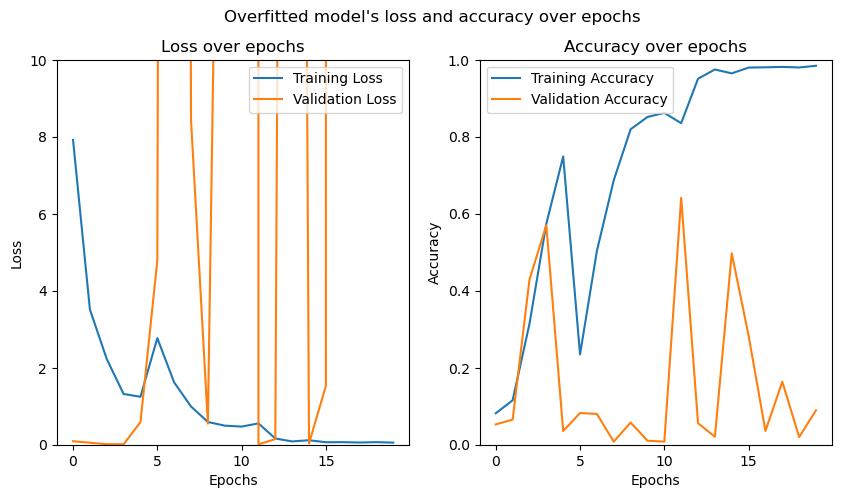

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # Create subplot 1 in a 1x2 grid
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.ylim(0, 10) # Set y-axis limit
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)  # Create subplot 2 in a 1x2 grid
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle("Overfitted model's loss and accuracy over epochs")

plt.show()

# Underfitting

Measures taken for underfitting:

- Removed Batch Normalization layer
- Added Dropout layers
- Reduced the model's complexity
- Changed optimizer types from Adam to SGD
- Higer learning rate than the optimized value

In [ ]:
class UnderFittedMobileNet(nn.Module):
    def __init__(self, in_channels, classes=2):
        super().__init__()
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, stride=2),
            # nn.BatchNorm2d(32), #remove this layer for creating underfitted model
            nn.ReLU(),
            Depth_Convolution_Block(32, stride=1),
            Convolution_Block(32),
            Depth_Convolution_Block(64),
            Convolution_Block(64),
            Depth_Convolution_Block(128, stride=1),
            Convolution_Block_Same(128),
            Depth_Convolution_Block(128),
            Convolution_Block(128),
            Depth_Convolution_Block(256, stride=1),
            Convolution_Block_Same(256),
            Depth_Convolution_Block(256, stride=2),
            Convolution_Block(256),
        )

        #To reduce the model's complexity, number of depthwise convolution block
        #and convolution block have been reduced from 5 to 2 in the code below
        self.list = []
        self.module_list_depth = nn.ModuleList([Depth_Convolution_Block(512, stride=1) for i in range(2)])
        self.module_list_conv = nn.ModuleList([Convolution_Block_Same(512) for i in range(2)])

        self.layers2 = nn.Sequential(
            Depth_Convolution_Block(512, stride=2),
            Convolution_Block(512),
            Depth_Convolution_Block(1024, stride=2),
            Convolution_Block_Same(1024),
            nn.AdaptiveAvgPool2d(7),
            nn.Flatten(),
            nn.Dropout(0.5), #added dropout rate
            nn.Linear(7*7*1024, classes),
        )

    def forward(self, x):
        x = self.layers1(x)
        for layer1, layer2 in zip(self.module_list_depth, self.module_list_conv):
            x = layer1(x)
            x = layer2(x)
        x = self.layers2(x)
        return x

In [ ]:
#Instantiate the model and send it to GPU. Also print out the model summary
underfitted_model = UnderFittedMobileNet(3, classes = 43)
underfitted_model.to(device)
summary(underfitted_model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             896
              ReLU-2         [-1, 32, 111, 111]               0
            Conv2d-3         [-1, 32, 111, 111]             320
       BatchNorm2d-4         [-1, 32, 111, 111]              64
Depth_Convolution_Block-5         [-1, 32, 111, 111]               0
            Conv2d-6         [-1, 64, 111, 111]          18,496
       BatchNorm2d-7         [-1, 64, 111, 111]             128
 Convolution_Block-8         [-1, 64, 111, 111]               0
            Conv2d-9           [-1, 64, 55, 55]             640
      BatchNorm2d-10           [-1, 64, 55, 55]             128
Depth_Convolution_Block-11           [-1, 64, 55, 55]               0
           Conv2d-12          [-1, 128, 55, 55]          73,856
      BatchNorm2d-13          [-1, 128, 55, 55]             256
Convolution_Block-14        

In [ ]:
#initialze the loss function
criterion = nn.CrossEntropyLoss()

#replace the admam optimizer with SDG and also keep the learning higher than optimized value and momentum as 0.9 for faster convergence.
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#train the model for 10 epoch
train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(underfitted_model, train_loader, val_loader, criterion, optimizer, device, 10)

[VALID] Epoch 10/10: 100%|██████████| 123/123 [00:07<00:00, 15.78it/s, classification loss=4.21, classification acc=0.0247]


In [ ]:
# Print the lists
print("Training Losses:", train_losses[-1])
print("Training Accuracies:", train_accuracies[-1])
print("Validation Losses:", val_losses[-1])
print("Validation Accuracies:", val_accuracies[-1])

Training Losses: 3.9223806462499735
Training Accuracies: 0.023265040097480802
Validation Losses: 0.03139905605244301
Validation Accuracies: 0.024744897959183672


In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # Create subplot 1 in a 1x2 grid
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.ylim(0, 10) # Set y-axis limit
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)  # Create subplot 2 in a 1x2 grid
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle("Underfitted model's loss and accuracy over epochs")

plt.show()

In [ ]:
test_accuracy = test_model(underfitted_model, test_loader)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.02391132224861441


### Display some results

In [ ]:
classes = {
    0: 'Speed limit (20km/h)',            1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',            3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',            5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',     7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',           9: 'No passing',
    10: 'No passing veh over 3.5 tons',   11: 'Right-of-way at intersection',
    12: 'Priority road',                  13: 'Yield',
    14: 'Stop',                           15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',      17: 'No entry',
    18: 'General caution',                19: 'Dangerous curve left',
    20: 'Dangerous curve right',          21: 'Double curve',
    22: 'Bumpy road',                     23: 'Slippery road',
    24: 'Road narrows on the right',      25: 'Road work',
    26: 'Traffic signals',                27: 'Pedestrians',
    28: 'Children crossing',              29: 'Bicycles crossing',
    30: 'Beware of ice/snow',             31: 'Wild animals crossing',
    32: 'End speed + passing limits',     33: 'Turn right ahead',
    34: 'Turn left ahead',                35: 'Ahead only',
    36: 'Go straight or right',           37: 'Go straight or left',
    38: 'Keep right',                     39: 'Keep left',
    40: 'Roundabout mandatory',           41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}

In [ ]:
def display_image(image_tensor, classification_output, actual_class):

    image = np.array(image_tensor.cpu())
    image = np.transpose(image, (1, 2, 0))  # (c, h, w) -> (h, w, c)

    classification_output = classification_output.cpu().squeeze().numpy()
    plt.imshow(image)
    plt.axis('off')

    plt.title(f'Predicted: {np.argmax(classification_output)}', color='red', loc='left')
    plt.title(f' Actual: {actual_class}', color='green', loc='right')

    plt.show()

In [ ]:
num_samples = len(val_loader.dataset)
random_indices = random.sample(range(num_samples), 2) # show X amount of random pics

for idx, (images, labels, bboxes) in enumerate(val_loader):
    if idx in random_indices:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            classification_output = model(images)

        for i in range(len(images)):
            image = images[i]
            actual_class = labels[i]

            display_image(image, classification_output[i], actual_class)